# Toxic Comment Classification – (CW2)

In [1]:
#Basic imports

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#ML imports

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score,
    multilabel_confusion_matrix
)

from sklearn.decomposition import TruncatedSVD

In [3]:
#Reproducibility

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## Step 1: Load Dataset

In [4]:
#Load parquet

DATA_PATH = "../dataset/train.parquet"
df = pd.read_parquet(DATA_PATH)

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (159571, 7)


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## Step 2: Inspect Columns and Missing Values

In [5]:
#Inspect

df.columns
df.isna().sum().sort_values(ascending=False)

comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

## Step 3: Select Input Text and Label Columns

In [6]:
#Define columns

TEXT_COL = "comment_text"
LABEL_COLS = [
    "toxic",
    "severe_toxic",
    "obscene",
    "threat",
    "insult",
    "identity_hate"
]

df[TEXT_COL] = df[TEXT_COL].fillna("").astype(str)

for col in LABEL_COLS:
    df[col] = df[col].fillna(0).astype(int)

X_raw = df[TEXT_COL]
y = df[LABEL_COLS]

X_raw.head(), y.head()

(0    Explanation\nWhy the edits made under my usern...
 1    D'aww! He matches this background colour I'm s...
 2    Hey man, I'm really not trying to edit war. It...
 3    "\nMore\nI can't make any real suggestions on ...
 4    You, sir, are my hero. Any chance you remember...
 Name: comment_text, dtype: object,
    toxic  severe_toxic  obscene  threat  insult  identity_hate
 0      0             0        0       0       0              0
 1      0             0        0       0       0              0
 2      0             0        0       0       0              0
 3      0             0        0       0       0              0
 4      0             0        0       0       0              0)

## Step 4: Analyze Class Imbalance

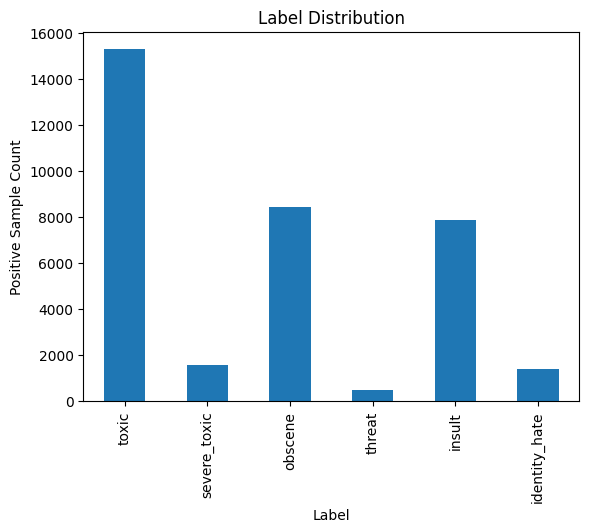

In [7]:
#Label distribution bar chart

label_counts = y.sum()

plt.figure()
label_counts.plot(kind="bar")
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Positive Sample Count")
plt.show()

## Step 5: Text Preprocessing

In [8]:
#Cleaning function

url_pattern = re.compile(r"http\S+|www\.\S+")
punct_pattern = re.compile(r"[^a-zA-Z0-9\s]")

def clean_text(text):
    text = text.lower()
    text = url_pattern.sub(" ", text)
    text = punct_pattern.sub(" ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean_text"] = df[TEXT_COL].apply(clean_text)
df[["comment_text", "clean_text"]].head()

,comment_text,clean_text
0,Explanation\nWhy the edits made under my usern...,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,d aww he matches this background colour i m se...
2,"Hey man, I'm really not trying to edit war. It...",hey man i m really not trying to edit war it s...
3,"""\nMore\nI can't make any real suggestions on ...",more i can t make any real suggestions on impr...
4,"You, sir, are my hero. Any chance you remember...",you sir are my hero any chance you remember wh...


## Step 6: Train-Test Split (80/20)

In [9]:
#Split

X_train, X_test, y_train, y_test = train_test_split(
    df["clean_text"],
    y,
    test_size=0.2,
    random_state=RANDOM_STATE
)

X_train.shape, X_test.shape

((127656,), (31915,))

## Step 7: TF-IDF Feature Extraction Settings

In [10]:
tfidf_params = {
    "stop_words": "english",
    "max_features": 10000,
    "ngram_range": (1, 2)
}

## Step 8: Train Model 1 — Multinomial Naive Bayes

In [11]:
#Build & train NB

nb_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(**tfidf_params)),
    ("clf", OneVsRestClassifier(MultinomialNB()))
])

nb_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('tfidf', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (string transformation) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


In [12]:
#Evaluate NB

nb_pred = nb_pipeline.predict(X_test)

nb_f1_micro = f1_score(y_test, nb_pred, average="micro")
nb_f1_macro = f1_score(y_test, nb_pred, average="macro")

nb_f1_micro, nb_f1_macro

(0.5969425801640567, 0.3697865543513652)

In [13]:
#NB report

print(classification_report(y_test, nb_pred, target_names=LABEL_COLS))

               precision    recall  f1-score   support

        toxic       0.91      0.52      0.66      3056
 severe_toxic       0.60      0.16      0.25       321
      obscene       0.90      0.50      0.65      1715
       threat       0.00      0.00      0.00        74
       insult       0.82      0.43      0.56      1614
identity_hate       0.55      0.05      0.10       294

    micro avg       0.88      0.45      0.60      7074
    macro avg       0.63      0.28      0.37      7074
 weighted avg       0.85      0.45      0.59      7074
  samples avg       0.05      0.04      0.04      7074



c:\Users\Personal\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Personal\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Personal\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn

## Step 9: Train Model 2 — Logistic Regression

In [14]:
#Build & train LR

lr_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(**tfidf_params)),
    ("clf", OneVsRestClassifier(LogisticRegression(max_iter=2000)))
])

lr_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('tfidf', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (string transformation) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


In [15]:
#Evaluate LR

lr_pred = lr_pipeline.predict(X_test)

lr_f1_micro = f1_score(y_test, lr_pred, average="micro")
lr_f1_macro = f1_score(y_test, lr_pred, average="macro")

lr_f1_micro, lr_f1_macro

(0.6770806213659637, 0.48839183136022024)

In [16]:
#LR report

print(classification_report(y_test, lr_pred, target_names=LABEL_COLS))

               precision    recall  f1-score   support

        toxic       0.91      0.61      0.73      3056
 severe_toxic       0.54      0.23      0.32       321
      obscene       0.92      0.63      0.75      1715
       threat       0.69      0.12      0.21        74
       insult       0.83      0.50      0.63      1614
identity_hate       0.76      0.18      0.30       294

    micro avg       0.88      0.55      0.68      7074
    macro avg       0.77      0.38      0.49      7074
 weighted avg       0.87      0.55      0.67      7074
  samples avg       0.06      0.05      0.05      7074



c:\Users\Personal\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Personal\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Personal\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn

## Step 10: Train Model 3 — Random Forest

In [18]:
#Build & train RF

rf_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(**tfidf_params)),
    
    # Dimensionality reduction
    ("svd", TruncatedSVD(
        n_components=200,
        random_state=RANDOM_STATE
    )),
    
    # Random Forest on dense features
    ("clf", OneVsRestClassifier(
        RandomForestClassifier(
            n_estimators=100,
            random_state=RANDOM_STATE,
            n_jobs=-1
        )
    ))
])

rf_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('tfidf', ...), ('svd', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (string transformation) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


In [19]:
#Evaluate RF

rf_pred = rf_pipeline.predict(X_test)

rf_f1_micro = f1_score(y_test, rf_pred, average="micro")
rf_f1_macro = f1_score(y_test, rf_pred, average="macro")

rf_f1_micro, rf_f1_macro

(0.5634882606612363, 0.38026505312616693)

In [20]:
#RF report

print(classification_report(y_test, rf_pred, target_names=LABEL_COLS))

               precision    recall  f1-score   support

        toxic       0.93      0.43      0.59      3056
 severe_toxic       0.58      0.12      0.21       321
      obscene       0.92      0.54      0.68      1715
       threat       0.67      0.08      0.14        74
       insult       0.77      0.39      0.52      1614
identity_hate       0.67      0.08      0.15       294

    micro avg       0.87      0.42      0.56      7074
    macro avg       0.75      0.27      0.38      7074
 weighted avg       0.86      0.42      0.55      7074
  samples avg       0.04      0.03      0.03      7074



c:\Users\Personal\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Personal\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Personal\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn

## Step 11: Compare All Models

In [21]:
#Comparison table

results_df = pd.DataFrame([
    {"Model": "Naive Bayes", "F1_micro": nb_f1_micro, "F1_macro": nb_f1_macro},
    {"Model": "Logistic Regression", "F1_micro": lr_f1_micro, "F1_macro": lr_f1_macro},
    {"Model": "Random Forest", "F1_micro": rf_f1_micro, "F1_macro": rf_f1_macro},
]).sort_values("F1_micro", ascending=False)

results_df

,Model,F1_micro,F1_macro
1,Logistic Regression,0.677081,0.488392
0,Naive Bayes,0.596943,0.369787
2,Random Forest,0.563488,0.380265


## Step 12: Visualize Model Performance

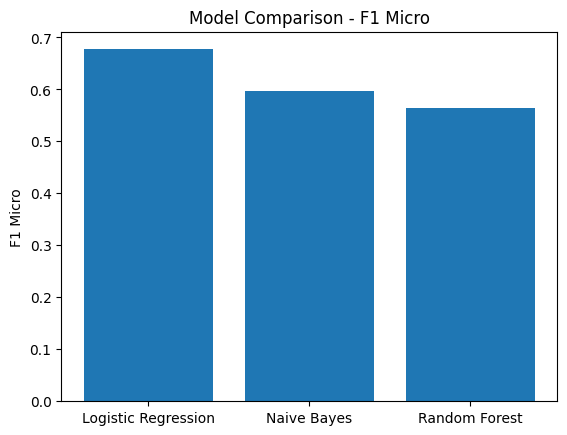

In [22]:
#F1 Micro bar chart

plt.figure()
plt.bar(results_df["Model"], results_df["F1_micro"])
plt.title("Model Comparison - F1 Micro")
plt.ylabel("F1 Micro")
plt.show()

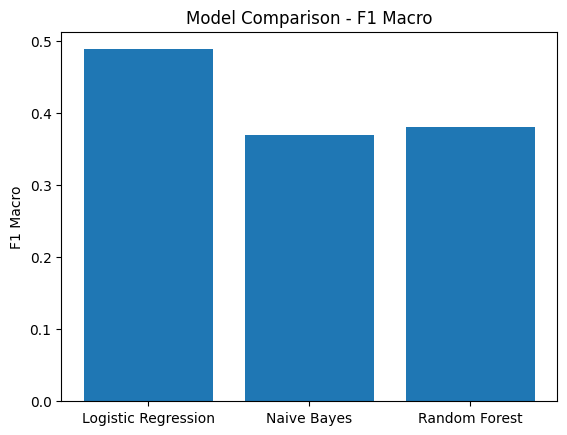

In [23]:
#F1 Macro bar chart

plt.figure()
plt.bar(results_df["Model"], results_df["F1_macro"])
plt.title("Model Comparison - F1 Macro")
plt.ylabel("F1 Macro")
plt.show()

## Step 13: Confusion Matrices (Best Model)


In [25]:
#Selecting best model

best_model_name = results_df.iloc[0]["Model"]

if best_model_name == "Naive Bayes":
    best_pred = nb_pred
elif best_model_name == "Logistic Regression":
    best_pred = lr_pred
else:
    best_pred = rf_pred

best_model_name

'Logistic Regression'

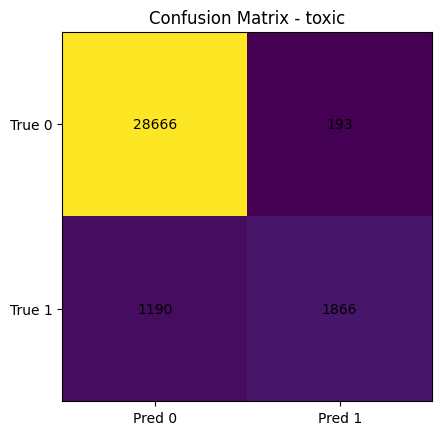

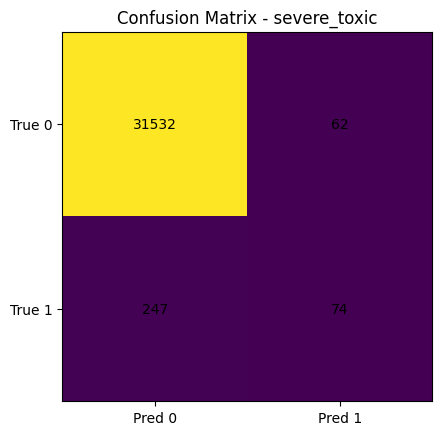

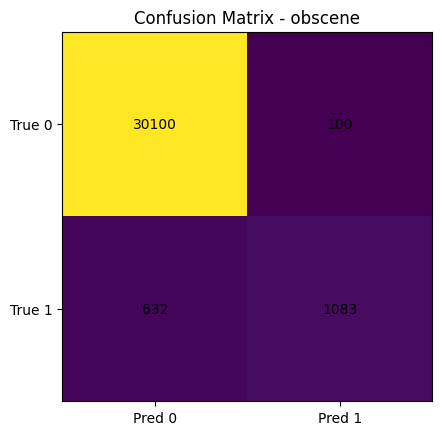

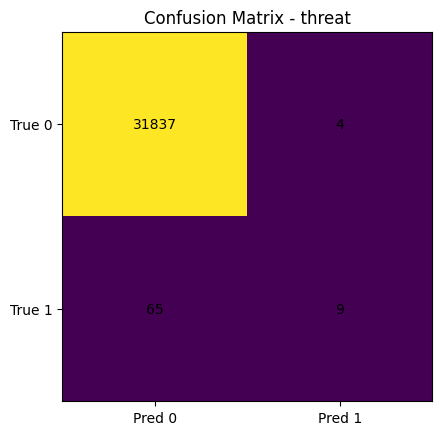

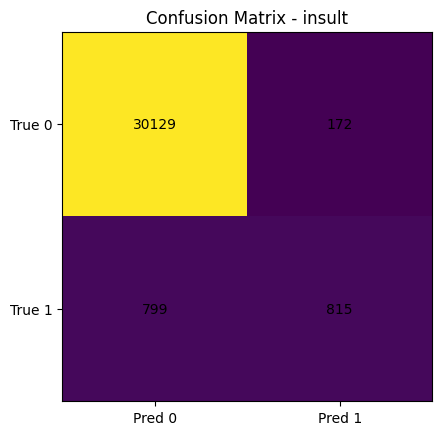

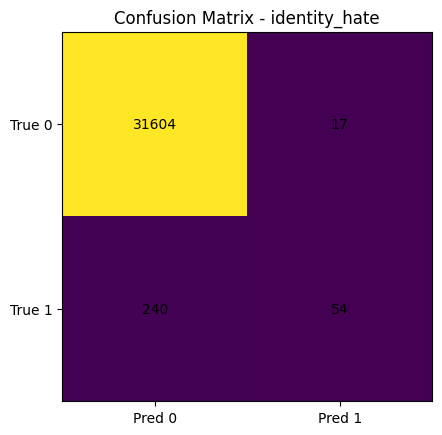

In [26]:
#Confusion matrices per label

cms = multilabel_confusion_matrix(y_test, best_pred)

for i, label in enumerate(LABEL_COLS):
    cm = cms[i]
    plt.figure()
    plt.imshow(cm)
    plt.title(f"Confusion Matrix - {label}")
    plt.xticks([0,1], ["Pred 0", "Pred 1"])
    plt.yticks([0,1], ["True 0", "True 1"])

    for (r, c), v in np.ndenumerate(cm):
        plt.text(c, r, str(v), ha="center", va="center")

    plt.show()

## Step 14: Demo Predictions on Unseen Text


In [32]:
#Demo

sample_comments = [
    "I really enjoyed this article. Thank you!",
    "You are disgusting and should be banned",
    "Go kill yourself",
    "This is stupid and obscene"
]

if best_model_name == "Naive Bayes":
    best_pipeline = nb_pipeline
elif best_model_name == "Logistic Regression":
    best_pipeline = lr_pipeline
else:
    best_pipeline = rf_pipeline

demo_df = pd.DataFrame(demo_preds, columns=LABEL_COLS)
demo_df["comment"] = sample_comments

# Reorder columns: comment first
demo_df = demo_df[["comment"] + LABEL_COLS]

demo_df

,comment,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,I really enjoyed this article. Thank you!,0,0,0,0,0,0
1,You are disgusting and should be banned,1,0,0,0,0,0
2,Go kill yourself,1,0,0,1,0,0
3,This is stupid and obscene,1,0,1,0,1,0


## Save models


In [33]:
import pickle
import os

os.makedirs("../models", exist_ok=True)

# Save label names
with open("../models/label_cols.pkl", "wb") as f:
    pickle.dump(LABEL_COLS, f)

# Save all models (optional but good practice)
with open("../models/nb_model.pkl", "wb") as f:
    pickle.dump(nb_pipeline, f)

with open("../models/lr_model.pkl", "wb") as f:
    pickle.dump(lr_pipeline, f)

with open("../models/rf_model.pkl", "wb") as f:
    pickle.dump(rf_pipeline, f)

# Save BEST model separately (this will be used by the app)
with open("../models/best_model.pkl", "wb") as f:
    pickle.dump(best_pipeline, f)

print("Models saved successfully.")
print("Best model:", best_model_name)

Models saved successfully.
Best model: Logistic Regression
